# Character Social Network Analysis

In [1]:
import pandas as pd
import numpy as np
import spacy
from spacy import displacy
import networkx as nx
import os
import re

import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
!python3 -m spacy download en_core_web_sm

In [3]:
# Load the model
nlp = spacy.load("en_core_web_sm")

# Increase the maximum length
nlp.max_length = 2500000

## Load the character data frame

In [4]:
# open csv file
character_df = pd.read_csv("characters_merged.csv")

In [5]:
# Clean up data frame

# Delete automatically generated column
del character_df["Unnamed: 0"]

# Add first name into a separate column
character_df['character_firstname'] = character_df['character_name'].apply(lambda x: x.split(' ', 1)[0])

# Replace 'Unknown' with np.nan
character_df["alias"].replace('Unknown',np.nan,inplace=True)

character_df["alias"] = character_df["alias"].astype(str)
character_df["alias"]

# Replace 'The' with empty string
character_df["alias"] = character_df["alias"].map(lambda x: x.replace("The ", ""))

# Remove a part of the Ramsay Bolton's aliases
character_df["alias"] = np.where(character_df['character_name']=='Ramsay Bolton',character_df['alias'].replace(re.compile(',Reek,Red Helm,Monster'), '', regex=True),character_df['alias'])

# Separate string by ',' and create a list
character_df['alias'] = character_df['alias'].str.split(',')


In [6]:
# Create book count column
books_count = character_df.groupby('character_name')['book'].size().reset_index(name='books_count')

# Merge the books_count with main dataframe
character_df = character_df.merge(books_count, on='character_name')

# Delete character duplicates to reduce computing load when replacing aliases
character_df = character_df.drop("book", axis=1)
character_df = character_df.drop_duplicates(subset=["character_name"], keep='last')

In [7]:
# change some character names for correct recognition
character_df.loc[character_df['character_name'].str.contains('Drogo'), 'character_name'] = 'Khal Drogo'
character_df.loc[character_df['character_name'].str.contains('Grey Worm'), 'character_firstname'] = 'Grey Worm'
character_df.loc[character_df['character_name'].str.contains('High Sparrow'), 'character_firstname'] = 'High Sparrow'
character_df.loc[character_df['character_name'].str.contains("Lord Commander's Raven"), 'character_firstname'] = "Lord Commander's Raven"
character_df.loc[character_df['character_name'].str.contains("Lord Sunglass"), 'character_firstname'] = "Lord Sunglass"
character_df.loc[character_df['character_name'].str.contains("Samwell Tarly"), 'alias'] = character_df.loc[character_df['character_name'].str.contains("Samwell Tarly"), 'alias'].apply(lambda x: ','.join(x))
character_df.loc[character_df['character_name'].str.contains("Benjen Stark"), 'alias'] = character_df.loc[character_df['character_name'].str.contains("Benjen Stark"), 'alias'].apply(lambda x: ','.join(x))
character_df.loc[character_df['character_name'].str.contains("Samwell Tarly"), "alias"] = "Sam :Sam,:Sam.:Sam?:Sam!:Ser Piggy:Lord of Ham:Lady Piggy:Piggy"
character_df.loc[character_df['character_name'].str.contains("Benjen Stark"), "alias"] = "Uncle Benjen:Ben Stark:Ben :Uncle Ben:Ben,:Ben.:Ben!:Ben?"
character_df.loc[character_df['character_name'].str.contains("Samwell Tarly"), 'alias'] = character_df.loc[character_df['character_name'].str.contains("Samwell Tarly"), 'alias'].str.split(":")
character_df.loc[character_df['character_name'].str.contains("Benjen Stark"), 'alias'] = character_df.loc[character_df['character_name'].str.contains("Benjen Stark"), 'alias'].str.split(":")


## Load books

In [9]:
# Get book names
path = "books_txt"
current_dir = os.getcwd()
abs_path = os.path.abspath(os.path.join(current_dir, path))

# Get all files in directory except temporary files
books = [book for book in os.listdir(abs_path) if os.path.isfile(os.path.join(path, book)) and not book.startswith('.')]
books.sort()

# Print all files
print(books)

['1_A_Game_Of_Thrones.txt', '2_A_Clash_Of_Kings.txt', '3_A_Storm_Of_Swords.txt', '4_A_Feast_For_Crows.txt', '5_A_Dance_With_Dragons.txt']


In [10]:
# Import function that raplaces character aliases with their full names in text
from utils.my_functions import replace_word_in_file

In [12]:
# Iterate through books to replace aliases with full names
for book in books:
    book_path = f"{abs_path}/{book}"

    # iterate through character aliases and replace in text
    for i, row in character_df.iterrows():
        for alias in row['alias']:
            replace_word_in_file(book_path, alias, row['character_name'])

In [14]:
# Sanity check
book_text = open(f"{abs_path}/{books[0]}").read()
book_text.count("Dany")

0

## Named entity recognition

In [15]:
# Open modified text files and append to a list
modified_books = []

for book in books:
    book_text = open(f"{abs_path}/{book}").read()
    modified_books.append(book_text)

In [16]:
# Apply named entity recognition to books
book_docs = []
for index, book in enumerate(modified_books):
    print(f"started processing book {index+1}")
    book_doc = nlp(book)
    book_docs.append(book_doc)

started processing book 1
started processing book 2
started processing book 3
started processing book 4
started processing book 5


In [17]:
# Visualize identified entities
displacy.render(book_docs[0][0:1000], style="ent", jupyter=True)

## Get name entity list per sentence

In [18]:
# Store identified entities from the first book
sent_entity_df = []

# Loop through sentences, store named entity list for each sentence
for sent in book_docs[0].sents:
    entity_list = [ent.text for ent in sent.ents]
    sent_entity_df.append({"sentence": sent, "entities": entity_list})
    
sent_entity_df = pd.DataFrame(sent_entity_df)


In [19]:
sent_entity_df.head()

,sentence,entities
0,"( , PROLOGUE, \n, We, should, start, back, ,, ...",[]
1,"(“, The, \n, wildlings, are, dead, ., ”, \n)",[]
2,"(“, Do, the, dead, frighten, you, ?, ”)",[]
3,"(Ser, Waymar, Royce, asked, with, just, the, h...",[Waymar Royce]
4,"(Gared, did, not, rise, to, the, bait, .)",[Gared]


In [20]:
# Import function that filters character entites
from utils.my_functions import filter_entity

In [35]:
# Filter out sentences that don't have any character entities
sent_entity_df['character_entities'] = sent_entity_df['entities'].apply(lambda x: filter_entity(x, character_df))
sent_entity_df_filtered = sent_entity_df[sent_entity_df['character_entities'].map(len) > 0]
sent_entity_df_filtered.head(5)

,sentence,entities,character_entities
3,"(Ser, Waymar, Royce, asked, with, just, the, h...",[Waymar Royce],[Waymar Royce]
4,"(Gared, did, not, rise, to, the, bait, .)",[Gared],[Gared]
23,"(Are, you, unmanned, by, the, dark, ,, Gared, ...",[Gared],[Gared]
48,"(Ser, Waymar, had, been, a, Sworn, Brother, of...","[Waymar, the Night’s Watch, less than half]",[Waymar]
103,"(“, What, do, you, think, might, have, killed,...",[Gared],[Gared]


In [110]:
# Check characters whose first names are the same as the names of other characters
duplicate_names = character_df[character_df['character_firstname'].duplicated(keep=False)]
pd.set_option('display.max_rows', None)
duplicate_names.head(20)

,character_name,alias,character_firstname,books_count
5,Aegon Frey,NaN,Aegon,4
10,Aegon I Targaryen,"[Aegon the Conqueror, Aegon the Dragonlord, Ae...",Aegon,5
11,Aemon (wildling),NaN,Aemon,1
13,Aemon Targaryen (Son of Maekar I),"[Aemon Targaryen, Uncle Maester]",Aemon,2
41,Alyn,NaN,Alyn,1
44,Alyn Haigh,NaN,Alyn,3
45,Alyn Orkwood,[Orkwood of Orkmont],Alyn,1
47,Alyn Stackspear,NaN,Alyn,2
59,Andrey Charlton,NaN,Andrey,1
60,Andrey Dalt,[Drey],Andrey,1


In [108]:
# Create data frame of main characters whose first names are the same as the names of other characters
main_characters = {"Brynden": "Brynden Tully", "Balon": "Balon IX Greyjoy", "Jeyne": "Jeyne Poole", "Jon": "Jon Snow",
                   "Lyanna": "Lyanna Stark", "Petyr": "Petyr Baelish", "Robert": "Robert I Baratheon",
                   "Tommen": "Tommen I Baratheon", "Tyrion": "Tyrion Lannister", "Viserys": "Viserys III Targaryen",
                   "Tywin": "Tywin Lannister"}

main_characters = pd.DataFrame.from_dict(main_characters, orient='index', columns=['full_name'])
main_characters = main_characters.reset_index()
main_characters = main_characters.rename(columns={'index':'first_name'})

In [37]:
# replace "nan" strings with NaN
character_df['alias'] = character_df['alias'].apply(lambda x: np.nan if (isinstance(x, list) and "nan" in x) else x)

In [38]:
# Import function that replaces first name with full name, so that short and full name instances of the 
# same character won't be traeted as different characters
from utils.my_functions import replace_name

In [ ]:
# Apply replace_name function to data frame to replace first name of characters with a full name
sent_entity_df_filtered['character_entities'] = sent_entity_df_filtered['character_entities'].apply(lambda lst: replace_name(lst, main_characters, character_df))

## Create relationships

In [56]:
# Reset index from 0 to lenght of df
sent_entity_df_filtered = sent_entity_df_filtered.reset_index(drop=True)

In [78]:
# Set a window size of 5 sentenses and create relationship pairs between characters
window_size = 5
relationships = []

for i in range(sent_entity_df_filtered.index[-1]):
    end_i = min(i+window_size, sent_entity_df_filtered.index[-1])
    char_list = sum((sent_entity_df_filtered.loc[i: end_i].character_entities), [])
    
    # Remove duplicated characters that are next to each other
    char_unique = [char_list[i] for i in range(len(char_list)) 
                   if (i==0) or char_list[i] != char_list[i-1]]
    
    if len(char_unique) > 1:
        for idx, a in enumerate(char_unique[:-1]):
            b = char_unique[idx + 1]
            relationships.append({"source": a, "target": b})

In [83]:
relationship_df = pd.DataFrame(relationships)
relationship_df.head(10)

,source,target
0,Waymar Royce,Gared
1,Gared,Waymar Royce
2,Waymar Royce,Gared
3,Gared,Waymar Royce
4,Gared,Waymar Royce
5,Waymar Royce,Gared
6,Gared,Waymar Royce
7,Waymar Royce,Gared
8,Gared,Waymar Royce
9,Gared,Waymar Royce


In [84]:
# Sort the pairs
relationship_df = pd.DataFrame(np.sort(relationship_df.values, axis = 1), columns = relationship_df.columns)

In [88]:
# Count the occurences of pair of characters and store it in value column
relationship_df["value"] = 1
relationship_df = relationship_df.groupby(["source","target"], sort=False, as_index=False).sum()

In [117]:
# Sort data frame by value column and display most frequently encountered relationships
relationship_sort = relationship_df.sort_values(by='value', ascending=False)
relationship_sort = relationship_sort.reset_index(drop=True)
relationship_sort.head(15)

,source,target,value
0,Ned Stark,Robert I Baratheon,1519
1,Ned Stark,Petyr Baelish,568
2,Grenn,Jon Snow,335
3,Benjen Stark,Jon Snow,327
4,Daenerys I Targaryen,Khal Drogo,265
5,Arya Stark,Sansa Stark,265
6,Jon Snow,Samwell Tarly,255
7,Bran Stark,Jon Snow,236
8,Jon Snow,Ned Stark,229
9,Arya Stark,Jeyne Poole,223


## Visualization of character relationships

In [130]:
# Create a graph from a pandas dataframe
G = nx.from_pandas_edgelist(relationship_df, 
                            source = "source", 
                            target = "target", 
                            edge_attr = "value", 
                            create_using = nx.Graph())

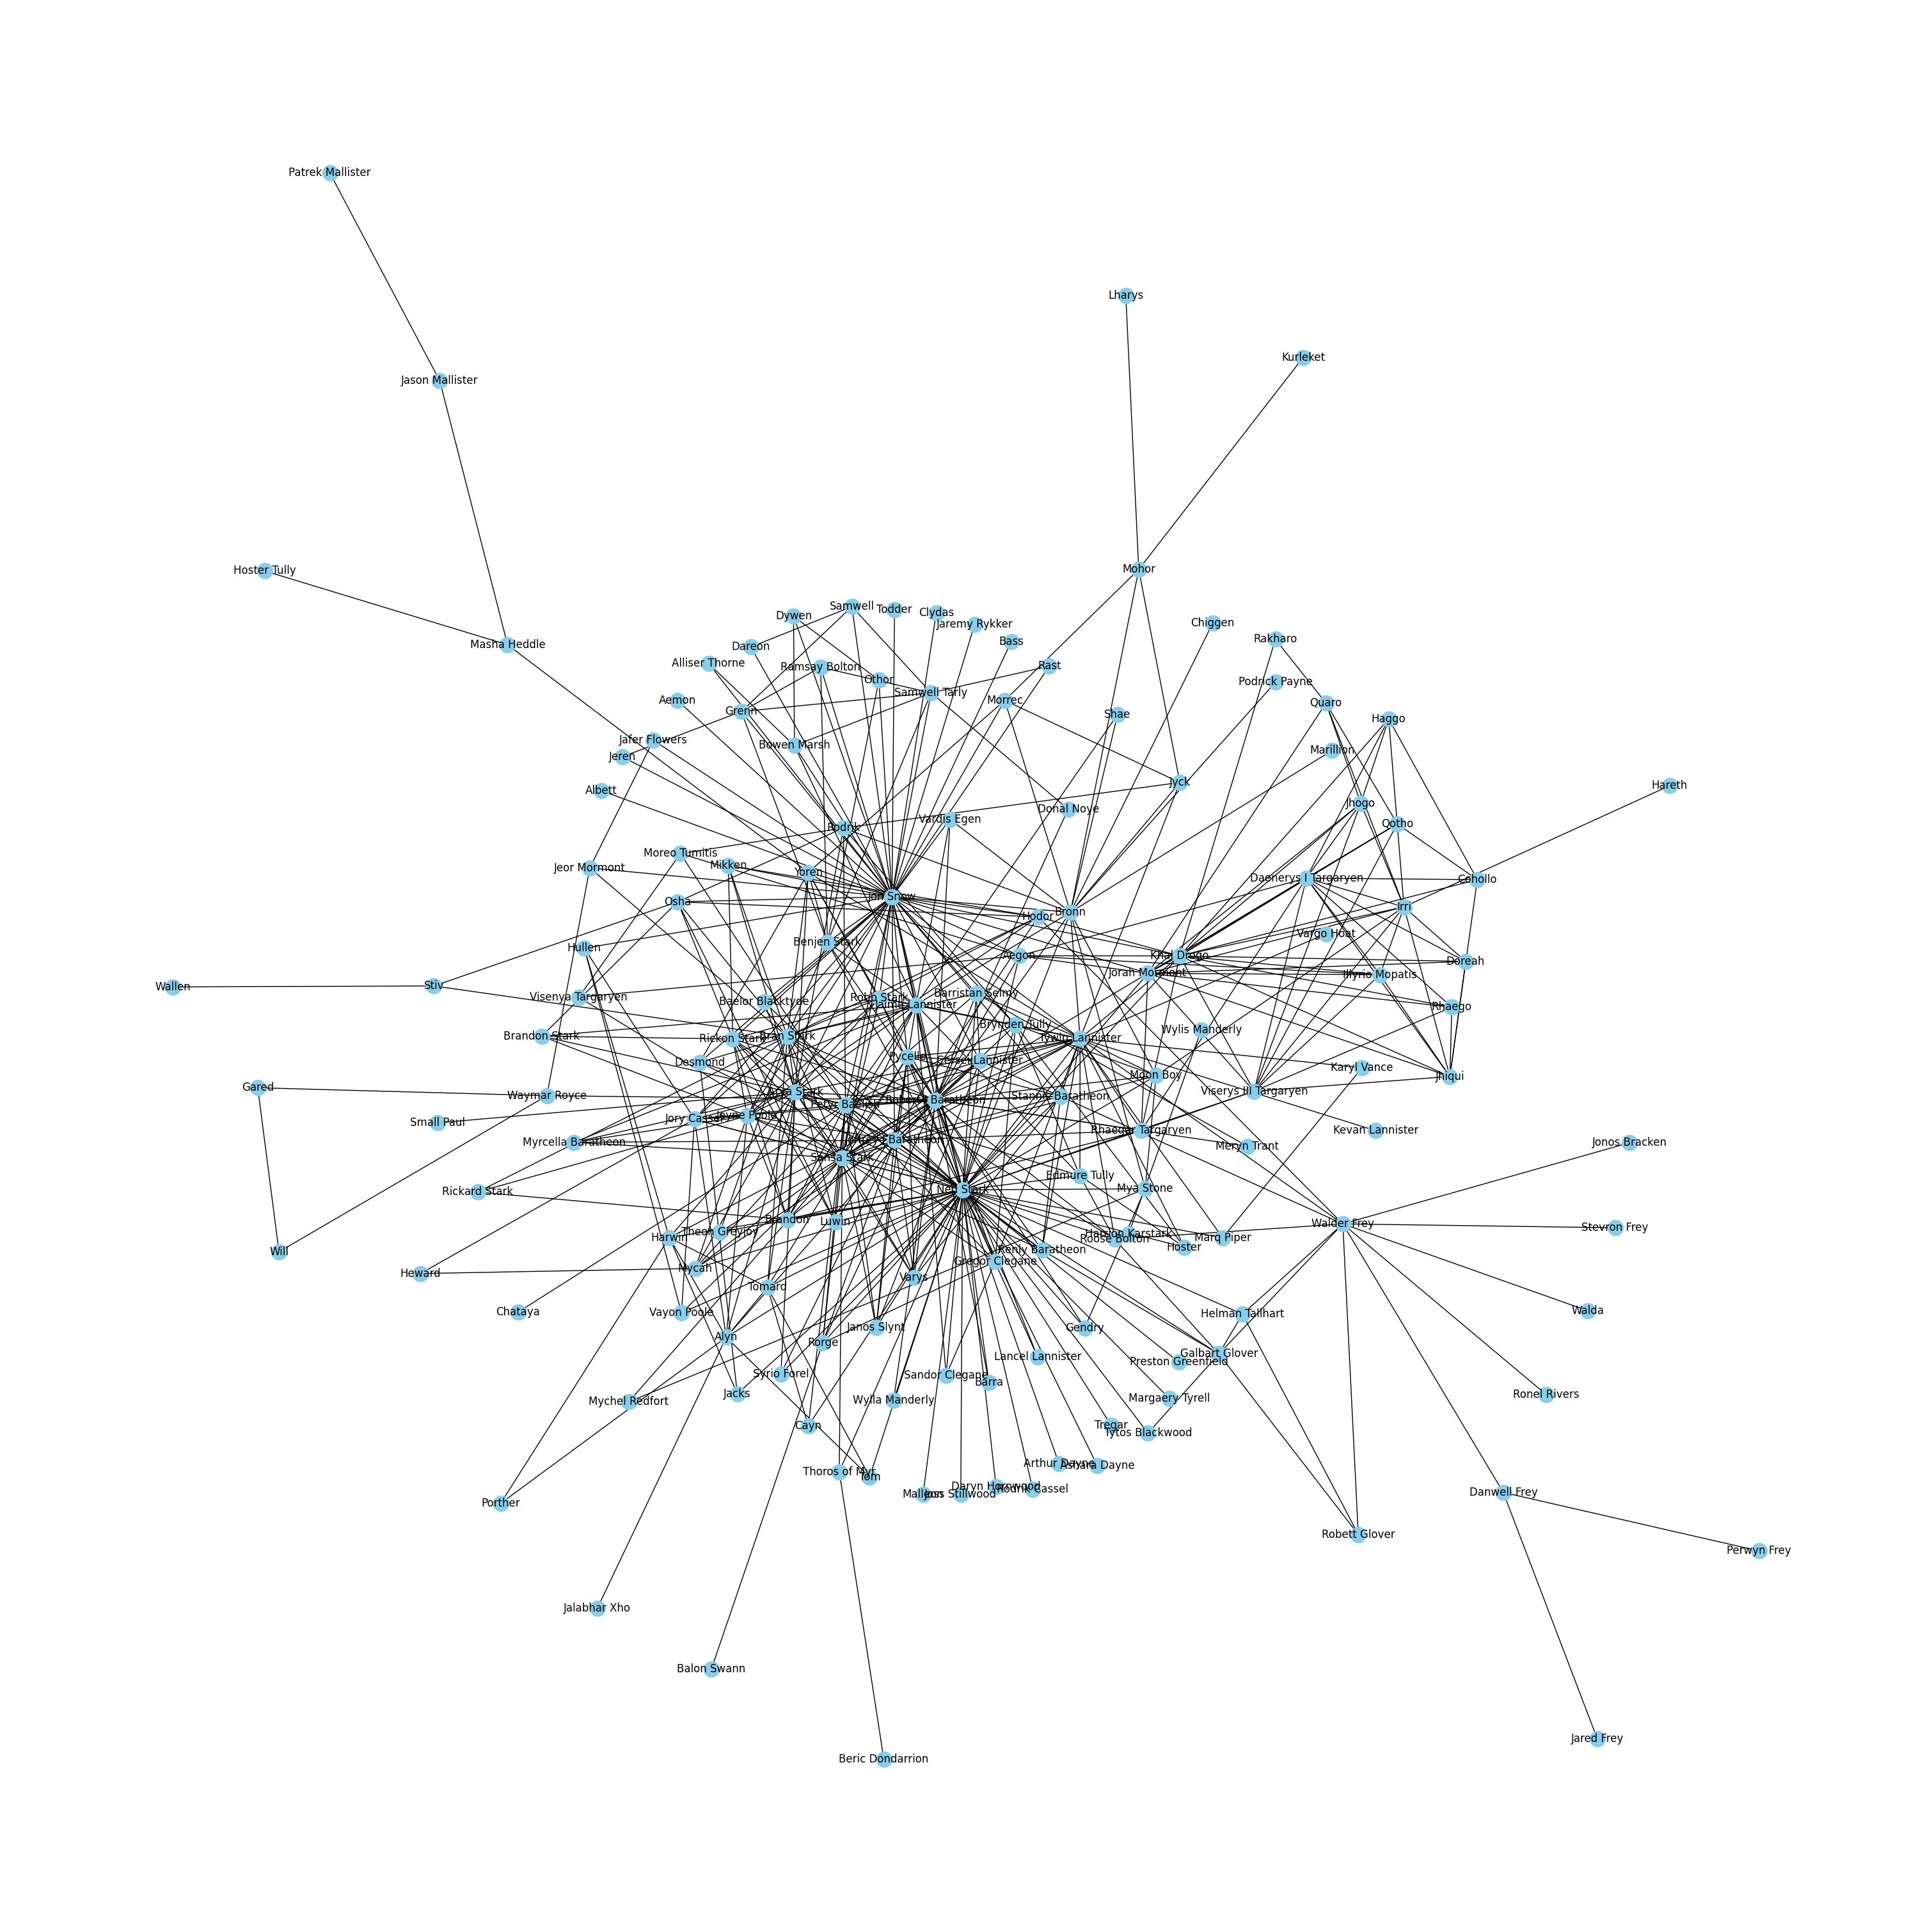

In [131]:
# Static plot of character relationships
plt.figure(figsize=(30,30))
pos = nx.kamada_kawai_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

In [125]:
# Dynamic plot of character relationships

from pyvis.network import Network

net = Network(notebook = True, width="1000px", height="700px", bgcolor='#222222', font_color='white')
node_degree = dict(G.degree)
nx.set_node_attributes(G, node_degree, 'size')
net.from_nx(G)
net.toggle_physics(True)
net.show_buttons(filter_=['physics'])
net.show("got.html")

Local cdn resources have problems on chrome/safari when used in jupyter-notebook. 


## Degree centrality analysis

In [132]:
# Create degree centrality data frame 
# Degree centrality is a measure of the importance of a node in a network. 
# It is defined as the number of connections (or edges) that a node has to other nodes in the network. 
degree_dict = nx.degree_centrality(G)
degree_df = pd.DataFrame.from_dict(degree_dict, orient='index', columns=['centrality'])

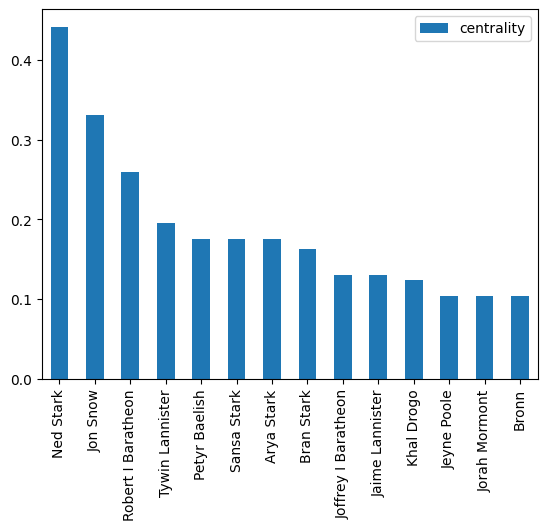

In [134]:
# Plot top 15 nodes
degree_df.sort_values('centrality', ascending=False)[0:14].plot(kind="bar");

## Community detection

In [147]:
import community.community_louvain as community_louvain

# Using best_partition function to detect communities in large networks of characters 
determine the best partition of a set of data into a specified number of clusters.
partition = community_louvain.best_partition(G)

In [150]:
# Visualize communities
nx.set_node_attributes(G, partition, 'group')
com_net = Network(notebook = True, width="1000px", height="700px", bgcolor='#222222', font_color='white')
com_net.from_nx(G)
com_net.show("got.html")

Local cdn resources have problems on chrome/safari when used in jupyter-notebook. 


## Evolution of characters' importance through books

In [154]:
# Change main_characters df to be more suited for other books
main_characters = {"Brynden": "Brynden Tully", "Balon": "Balon IX Greyjoy", "Jeyne": "Jeyne Westerling", "Jon": "Jon Snow",
                   "Lyanna": "Lyanna Stark", "Petyr": "Petyr Baelish", "Robert": "Robert I Baratheon",
                   "Tommen": "Tommen I Baratheon", "Tyrion": "Tyrion Lannister", "Viserys": "Viserys III Targaryen",
                   "Tywin": "Tywin Lannister"}

main_characters = pd.DataFrame.from_dict(main_characters, orient='index', columns=['full_name'])
main_characters = main_characters.reset_index()
main_characters = main_characters.rename(columns={'index':'first_name'})

In [156]:
# Do the previous steps for the rest book

books_graph = []

# Append edge list for the 1 book to books_graph list
books_graph.append(G)

# Go through book 2 - 5
for index, book in enumerate(book_docs[1:]):
    
    # Track loop progress
    print(f'Processing book {index+2}')
    
    # Create entities data frame
    sent_entity_df = []
    for sent in book.sents:
        entity_list = [ent.text for ent in sent.ents]
        sent_entity_df.append({"sentence": sent, "entities": entity_list})
    sent_entity_df = pd.DataFrame(sent_entity_df)
    print(f"Created entities dataframe for book {index+2}")

    # Filter out sentences that don't have any character entities
    sent_entity_df['character_entities'] = sent_entity_df['entities'].apply(lambda x: filter_entity(x, character_df))
    sent_entity_df_filtered = sent_entity_df[sent_entity_df['character_entities'].map(len) > 0]

    # Apply replace_name function to data frame to replace first name of characters with a full name
    sent_entity_df_filtered['character_entities'] = sent_entity_df_filtered['character_entities'].apply(lambda lst: replace_name(lst, main_characters, character_df))
    print(f"Filtered entities dataframe for book {index+2} and replaced first names with full names")
    
    # Reset index from 0 to lenght of df
    sent_entity_df_filtered = sent_entity_df_filtered.reset_index(drop=True)

    # Create relationship pairs between characters
    relationships = []
    for i in range(sent_entity_df_filtered.index[-1]):
        end_i = min(i+window_size, sent_entity_df_filtered.index[-1])
        char_list = sum((sent_entity_df_filtered.loc[i: end_i].character_entities), [])

        # Remove duplicated characters that are next to each other
        char_unique = [char_list[i] for i in range(len(char_list)) 
                       if (i==0) or char_list[i] != char_list[i-1]]

        if len(char_unique) > 1:
            for idx, a in enumerate(char_unique[:-1]):
                b = char_unique[idx + 1]
                relationships.append({"source": a, "target": b})
    relationship_df = pd.DataFrame(relationships)
    print(f"Created relationship dataframe for book {index+2}")

    # Sort the pairs
    relationship_df = pd.DataFrame(np.sort(relationship_df.values, axis = 1), columns = relationship_df.columns)

    # Count the occurences of pair of characters and store it in value column
    relationship_df["value"] = 1
    relationship_df = relationship_df.groupby(["source","target"], sort=False, as_index=False).sum()
    print(f"Counted pairs and dropped duclicates from relationship df {index+2}")

    G = nx.from_pandas_edgelist(relationship_df, 
                                source = "source", 
                                target = "target", 
                                edge_attr = "value", 
                                create_using = nx.Graph())
    books_graph.append(G)
    print(f"Created and appended edge list for book {index+2}")

Processing book 2
Created entities dataframe for book 2


/var/folders/tf/5gs_4mlx2n16pz_vsy30cc7w0000gn/T/ipykernel_901/820755897.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sent_entity_df_filtered['character_entities'] = sent_entity_df_filtered['character_entities'].apply(lambda lst: replace_name(lst, main_characters, character_df))


Filtered entities dataframe for book 2 and replaced first names with full names
Created relationship dataframe for book 2
Counted pairs and dropped duclicates from relationship df 2
Created and appended edge list for book 2
Processing book 3
Created entities dataframe for book 3


/var/folders/tf/5gs_4mlx2n16pz_vsy30cc7w0000gn/T/ipykernel_901/820755897.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sent_entity_df_filtered['character_entities'] = sent_entity_df_filtered['character_entities'].apply(lambda lst: replace_name(lst, main_characters, character_df))


Filtered entities dataframe for book 3 and replaced first names with full names
Created relationship dataframe for book 3
Counted pairs and dropped duclicates from relationship df 3
Created and appended edge list for book 3
Processing book 4
Created entities dataframe for book 4


/var/folders/tf/5gs_4mlx2n16pz_vsy30cc7w0000gn/T/ipykernel_901/820755897.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sent_entity_df_filtered['character_entities'] = sent_entity_df_filtered['character_entities'].apply(lambda lst: replace_name(lst, main_characters, character_df))


Filtered entities dataframe for book 4 and replaced first names with full names
Created relationship dataframe for book 4
Counted pairs and dropped duclicates from relationship df 4
Created and appended edge list for book 4
Processing book 5
Created entities dataframe for book 5


/var/folders/tf/5gs_4mlx2n16pz_vsy30cc7w0000gn/T/ipykernel_901/820755897.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sent_entity_df_filtered['character_entities'] = sent_entity_df_filtered['character_entities'].apply(lambda lst: replace_name(lst, main_characters, character_df))


Filtered entities dataframe for book 5 and replaced first names with full names
Created relationship dataframe for book 5
Counted pairs and dropped duclicates from relationship df 5
Created and appended edge list for book 5


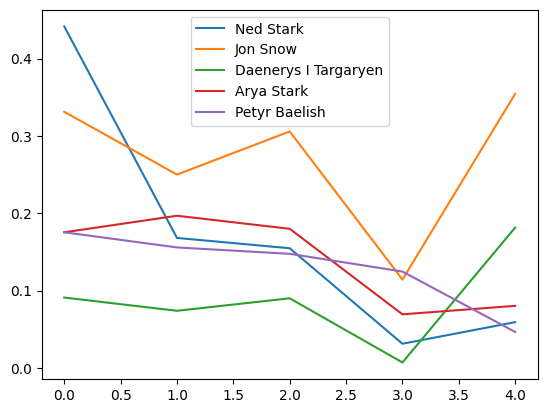

In [159]:
# Creating a list of degree centrality of all the books
evol = [nx.degree_centrality(book) for book in books_graph]

# Creating a DataFrame from the list of degree centralities in all the books
degree_evol_df = pd.DataFrame.from_records(evol)

# Plotting the degree centrality evolution of 5 main characters
degree_evol_df[["Ned Stark", "Jon Snow", "Daenerys I Targaryen", "Arya Stark", "Petyr Baelish"]].plot();